In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library


<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0960360, r0923943, r0960062, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 

Students:
- Albert Arlà Romero: r0960360
- Gonzalo Fernández Moreno: r0923943
- Iraklis Premptis : r0960363
- Mathis Gineste : r0960062


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    'train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    'test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [6]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [7]:
# parameter to play with 
FACE_SIZE = (150, 150)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



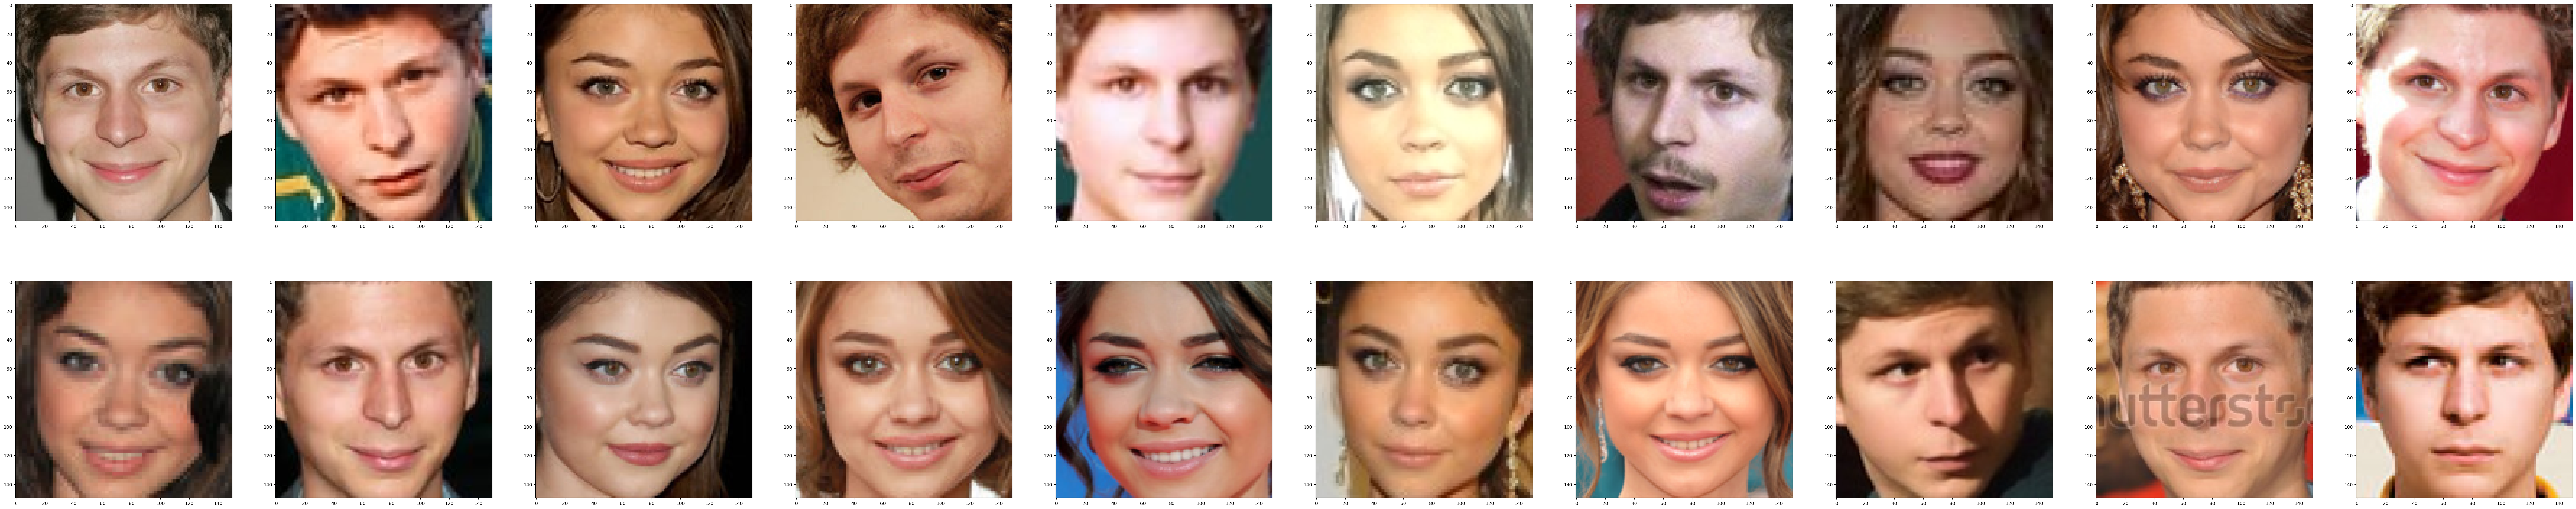

In [8]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


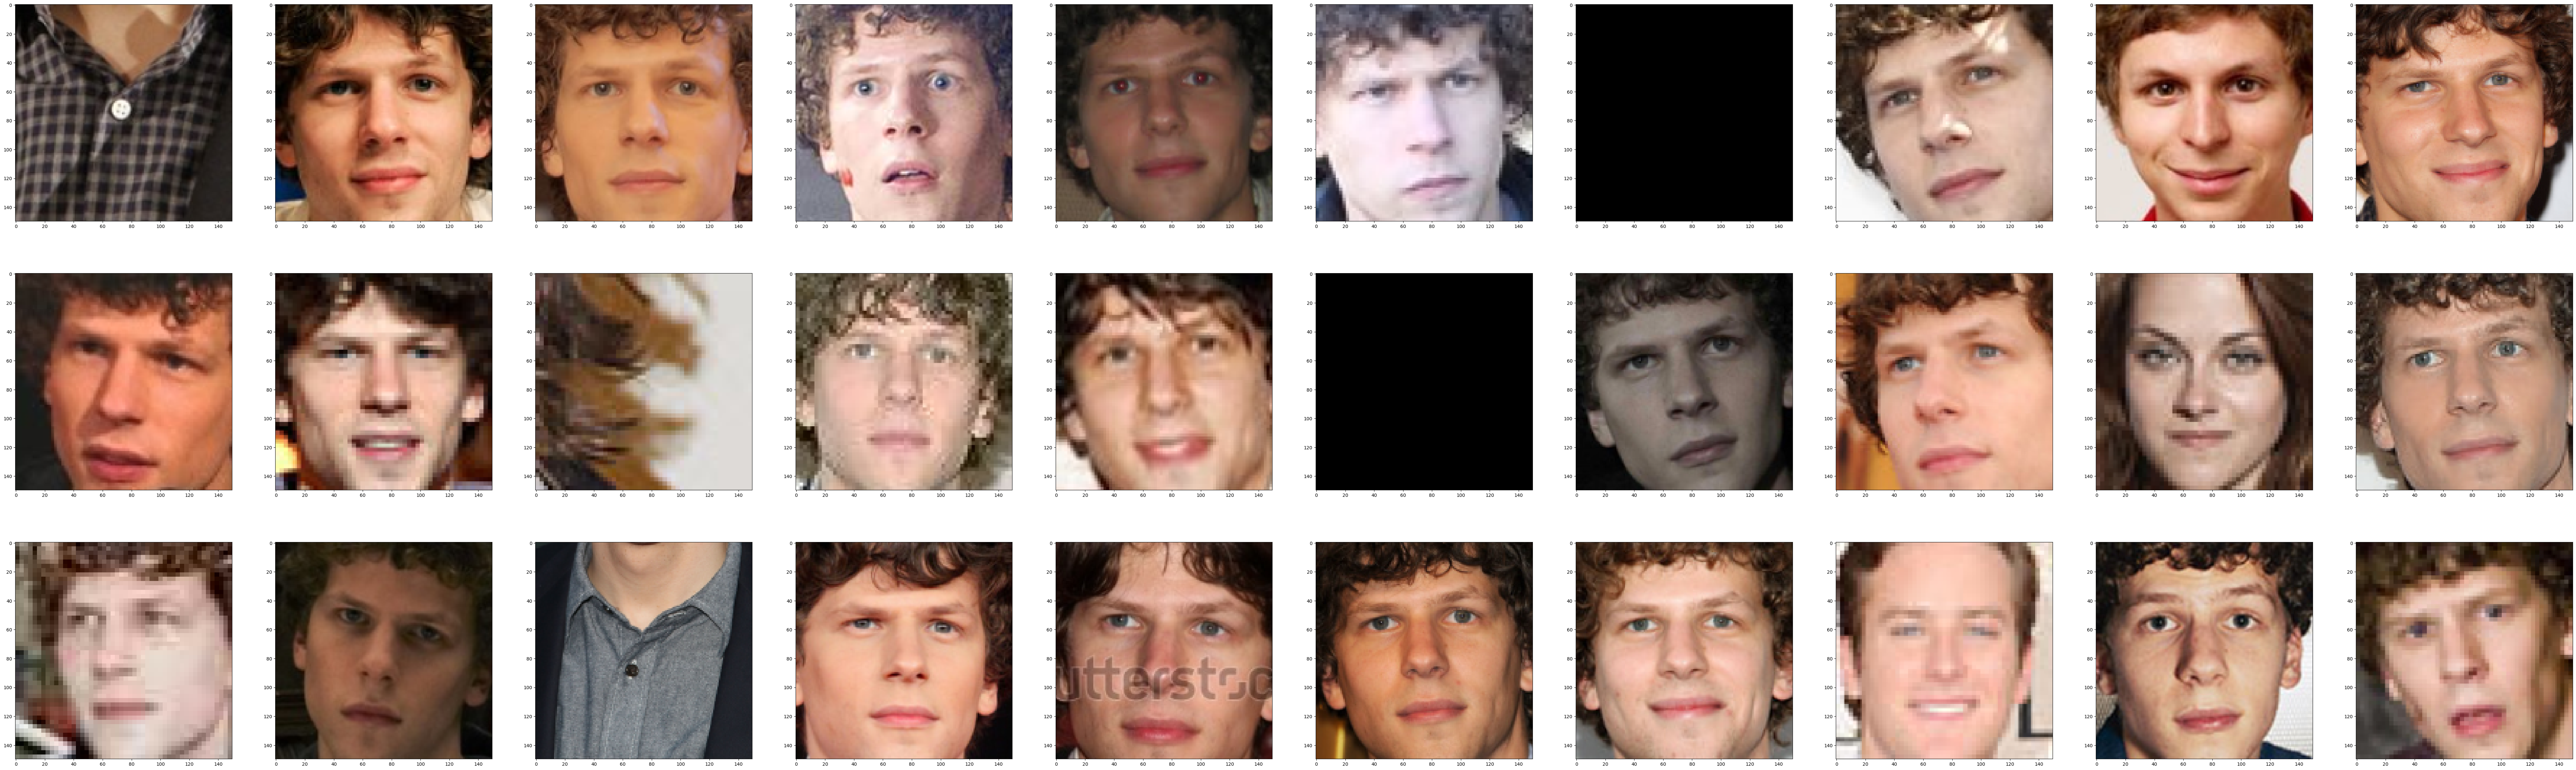

In [9]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


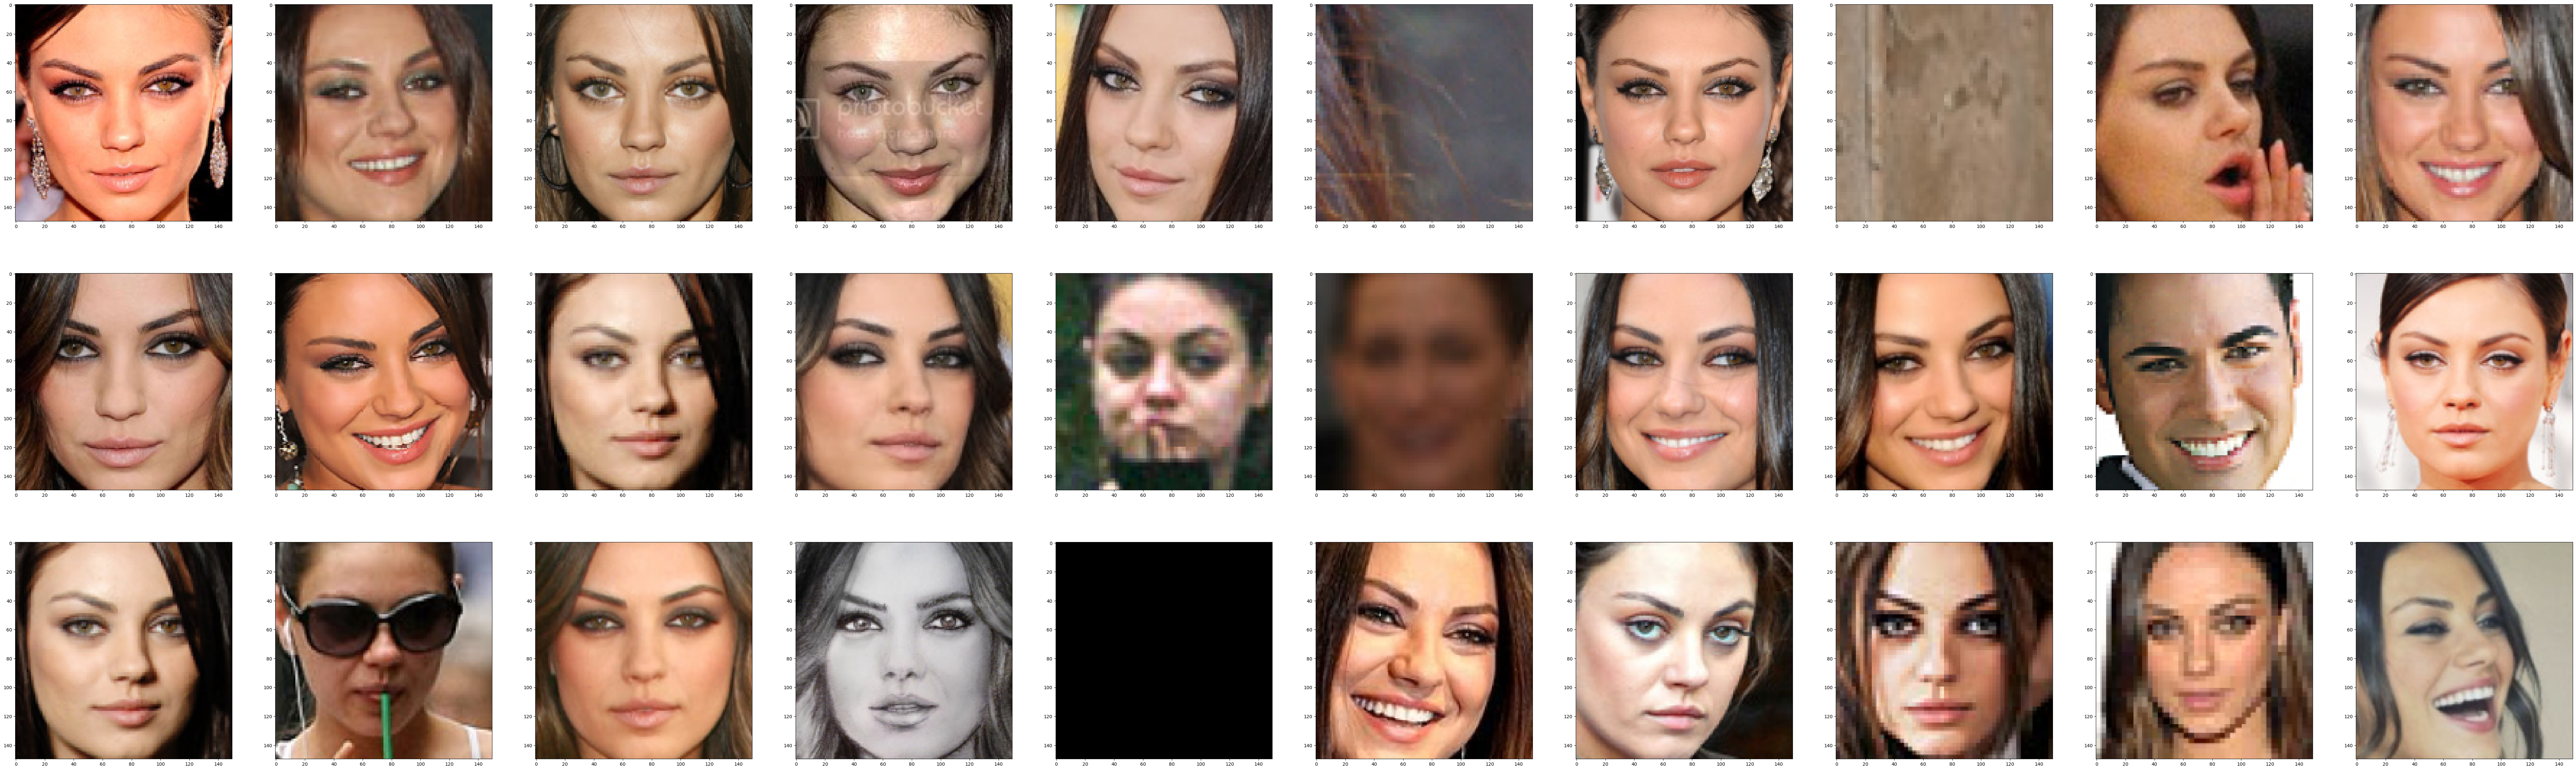

In [10]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [11]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [12]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
This code is an implementation of an image feature extraction tool called HOG (Histogram of Oriented Gradients). HOG is a widely used technique in image processing and computer vision, which is used to extract unique features from an image.

A class called HOGFeatureExtractor is defined that defines the parameters for HOG feature extraction. The class contains a transform method that is used to extract HOG features from images.

Then, the code loads the training and test sets and the images are read from these sets using OpenCV.

Finally, the code uses the HOGFeatureExtractor class to extract the HOG features from the images in the training and test sets and returns the results in the form of a feature list.


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from skimage.transform import resize
from skimage import feature
from skimage import exposure

class HOG():
    def __init__(self, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), normalize=True, visualize=True):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.normalize = normalize
 
    def describe(self, image):
       
        histogram, histogram_image = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell,cells_per_block=self.cells_per_block, block_norm='L2',visualize=True)
        histogram[histogram < 0] = 0  # No queremos valores negativos.
 
        return histogram, histogram_image

class HOGFeatureExtractor:
    def __init__(self, cell_size=(8, 8), block_size=(2, 2), nbins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins
        
    def transform_opencv(self, X):
        hog_features = []

        for img in X:        
            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
           
            # Compute HOG features
            hog = cv2.HOGDescriptor(_winSize=(gray.shape[1] // self.cell_size[1] * self.cell_size[1],
                                              gray.shape[0] // self.cell_size[0] * self.cell_size[0]),
                                    _blockSize=(self.block_size[1] * self.cell_size[1],
                                                self.block_size[0] * self.cell_size[0]),
                                    _blockStride=(self.cell_size[1], self.cell_size[0]),
                                    _cellSize=(self.cell_size[1], self.cell_size[0]),
                                    _nbins=self.nbins, _gammaCorrection=0)

            hog_feature = hog.compute(gray)
            hog_features.append(hog_feature)

        return hog_features


### SIFT transform

SIFT (Scale-Invariant Feature Transform) is a computer vision algorithm for detecting and describing local features in images. The algorithm is designed to be invariant to scale, rotation, and affine distortion, making it robust to changes in viewpoint and illumination.

The SIFT algorithm works by detecting keypoints in an image based on significant changes in gradient magnitude and direction, and then computing a local descriptor for each keypoint based on the gradient orientations in the surrounding image patch.

We create the SIFTFeatureExtractor class which implements the SIFT algorithm using OpenCV functions and tools. 3 parameters are used, namely nfeatures is the number of best features to be kept from an image(by deafult 0, meaning that we don't pose a limit), and contrastThreshold and edgeThreshold which determine the number and quality of the detected features.

However, not all of the features extracted using this class are useful, no matter how carefully one chooses the hyperparameters (see visualization results below for a better insight). In order to retain those features that are useful (i.e. discriminative and robust) and use them for classification, we propose an algorithm which, given the train set of images, can identify the best features that have the above mentioned properties. This is done by matching the computed features between each pair of images in the train set and keeping track of the good and bad matches they give, where good are considered the successful matches between images of the same class and bad the ones between images of different classes. Eventually, the features that have a relatively high good over bad matches ratio are retained, whereas the rest are discarded. For details regarding the results of the algorithm see t-SNE plots below.

In [14]:
class SIFTFeatureExtractor:
    
    def __init__(self, nfeatures=0, contrastThreshold=0.06, edgeThreshold=15):
        self.nfeatures = nfeatures
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        
        # Initialize the SIFT feature detector with the given parameters
        self.sift = cv2.SIFT_create(
            nfeatures=self.nfeatures,
            contrastThreshold=self.contrastThreshold,
            edgeThreshold=self.edgeThreshold)
        
    def transform(self, X, mask=None):
        """
        Extract SIFT features from the given input images X.
        
        Parameters
        ----------
        X : numpy array ((n_images,) 100, 100, 3)
            Can be a single image or a set of n_images
            Input images to extract features from.
        
        mask : numpy array, optional
            Mask to search only a specific part of
            the face (e.g. eyes, nose, lips).
            
        Returns
        -------
        list of numpy arrays
            SIFT descriptors for each input image.
        """
        
        # Extract SIFT features for each input image
        sift_descriptors = []
        for img in X:
            img = img.astype(np.uint8)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, des = self.sift.detectAndCompute(gray, mask)
            sift_descriptors.append(des)
    
        return sift_descriptors

In [15]:
# Algorithm for extracting useful SIFT features (discriminative
# and robust) and discarding fuzzy ones from the train set

# Preparation - useful functions 

def clean_and_assign_labels(data, y):
    """
    Takes the list of descriptors obtained using the 
    SIFTFeatureExtractor and cleans it, i.e. discards:
    - empty (None) elements and 
    - those with less than 2 descriptors
        (unuseful because they cannot be used for 2NN matching)
    Also, it assigns a label (1, 2 or 0) to each descriptor 
    according to the face it corresponds to.
    
    Returns
    -------
    n_kps : list containing the number of keypoints
            (features) found in each image
    
    descriptors : numpy array containing all the features after cleaning
    
    labels : list of assigned labels (1,2 or 0), same length
             with the 0-dimension of the descriptors array
    """
    
    descriptors = np.zeros((1,128), dtype=np.uint8)
    labels = []
    n_kps = []
    
    for i, des in enumerate(data):
        if des is not None and len(des)>1:
            n_kps.append(len(des))
            descriptors = np.append(descriptors, des, axis=0)
            for j in range(len(des)):
                labels.append(y[i])
                
    labels = np.array(labels, int)
    return n_kps, descriptors[1:], labels    


def select_best_features(n_kps, descriptors, labels, ratio=0.75):
    """
    Find and retain those features that best describe the data
    (discriminative and robust) and discard the rest.
    
    Returns
    -------
    best_features : numpy array containing the more 
                    discriminative and robust features
                    
    labels : 1D numpy array with the corresponding labels (1, 2  or 0)
             for the retained descriptors
    """
    
    bf = cv2.BFMatcher()
    
    n_imgs = len(n_kps)
    best_features = np.zeros((1,128), dtype=np.uint8)
    labels_ = []

    for i in range(n_imgs):
        good_matches = np.zeros((n_kps[i],), int)
        bad_matches = np.zeros((n_kps[i],), int)
        idx1 = i if i==0 else sum(n_kps[:i])
        idx2 = idx1+n_kps[i]
        des1 = descriptors[idx1:idx2]
        label1 = labels[idx1]
        for j in range(n_imgs):
            idx1 = sum(n_kps[:j])
            idx2 = idx1+n_kps[j]
            des2 = descriptors[idx1:idx2]
            label2 = labels[idx1]
            
            # Find matches using 2NN 
            matches = bf.knnMatch(des1,des2,k=2)
            
            # Apply the ratio test proposed by Lowe to consider
            # only good matches between the two images
            for m,n in matches:
                if m.distance < ratio*n.distance:
                    if label1 == label2:
                        # Robustness
                        good_matches[m.queryIdx] += 1
                    else:
                        # Discriminativeness
                        bad_matches[m.queryIdx] += 1
        
        # Keep the features that are both robust (plenty of good matches)
        # and discriminative (few or no bad_matches)
        #good_bad_ratio = good_matches/bad_matches
        to_append = des1[np.logical_and(good_matches>3, bad_matches<3)]
        best_features = np.append(best_features, to_append, axis=0)
        for i in range(len(to_append)):
            labels_.append(label1)

    best_features = best_features[1:]
    labels_ = np.array(labels_, int)
    
    # Remove duplicate features
    df = pd.DataFrame(best_features)
    index = df.duplicated()
    df = df.drop_duplicates()
    best_features = df.to_numpy()
    labels_ = labels_[index == False]
    
    return best_features, labels_


def create_mask(x_lower, x_upper, y_lower, y_upper):
    """
    Create a mask to use when applying the SIFT transform
    in order to extract features from a specific part of 
    the image. E.g (for images of shape (100,100))
    - For the face area use: (20, 90, 15, 85)
    - For the eyes use: (20, 50, 15, 85)
    
    x --> vertical side
    y --> horizontal side
    """
    
    mask = np.zeros((150,150), np.uint8)
    mask[x_lower:x_upper, y_lower:y_upper] = 255
    
    return mask

Now , we will use this algorithm to extract the SIFT features. Before doing this we should notice that the train set does not contain the same amount of data from each class, namely there are less images from class 0. In order for the classifier to work robustly we need to have a balanced amount of features describing each class. Therefore, we will double the images of class 0 to be able to extract more features from them. Note that this will result in duplicate features which we finally should remove.

In [59]:
# Augment the train set
copy = train_X[train_y == 0]
train_X_rich = np.concatenate((train_X,copy), axis=0)
train_y_rich = np.append(train_y, np.zeros((20,), dtype=int))
print(train_X_rich.shape)
print(train_y_rich.shape)

# # Extract features from train set using SIFT transform
# # Search for features from the area of the eyes and nose
# sift = SIFTFeatureExtractor(contrastThreshold=0.04, edgeThreshold=20)
# mask = create_mask(30, 100, 20, 120)
# sift_features = sift.transform(train_X_rich, mask)
# n_kps, features, labels = clean_and_assign_labels(sift_features, train_y_rich)

# # Select the best features and their corresponding labels
# best_features, labels_ = select_best_features(n_kps, features, labels)

# Report results
print("Total number of features extracted:", features.shape[0], "\n")
print("Number of best features selected:", best_features.shape[0])
print("Features for class 1 (Jesse):", best_features[labels_==1].shape[0])
print("Features for class 2 (Mila):", best_features[labels_==2].shape[0])
print("Features for class 0 (false face):", best_features[labels_==0].shape[0])

(400, 150, 150, 3)
(340,)
Total number of features extracted: 4390 

Number of best features selected: 612
Features for class 1 (Jesse): 153
Features for class 2 (Mila): 179
Features for class 0 (false face): 280


### 1.1.1. t-SNE Plots
The following code uses the t-SNE tool to transform the HOG features of the images into a two-dimensional space, allowing them to be visualized in a scatter plot. 

To do this, first a t-SNE object with two components is created and fitted to the HOG features extracted from the training and test images. Then, two arrays of zeros with maximum size of all HOG features are created, where the features from the training and test images are stored. Flatten() is used to flatten each feature vector and they are stored in the corresponding matrices. We apply t-SNE to each matrix and store the transformed features in the variables train_hog_features_2d and test_hog_features_2d. 

Finally, the transformed features are displayed in two different scatter plots, one for the training images and one for the test images. In each plot, the points corresponding to the transformed features are displayed and given an appropriate title.

Each plot represents a 2D visualization of the extracted features for each dataset (train_set and test_set). Each point in the plot corresponds to an image of the dataset and is positioned according to its HOG features.

The x- and y-axis values have no specific interpretation, but are simply two arbitrary dimensions along which the dimensionality of the features has been reduced. The relative position of the points on the graph represents the similarity or difference between the features of the images. That is, images that are close together on the graph have more similar features than images that are far apart on the graph.

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class tsne_utils():
    def __init__(self):
        pass
    
    def generate_2d_data(self, data, n_components=2, random_state=0):
        # Create t-SNE object
        tsne = TSNE(n_components=n_components, random_state=random_state)
       
        # Transform HOG features into 2D space using t-SNE
        max_shape = max([feat.shape[0] for feat in data])
        matrix = np.zeros((len(data), max_shape))
        for i, feat in enumerate(data):
            matrix[i, :feat.shape[0]] = feat.flatten()
        data_2d = tsne.fit_transform(matrix)
        
        return data_2d

    # scale and move the coordinates so they fit [0; 1] range
    def scale_to_01_range(self, x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))

        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)

        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range

    def plot_tsne(self,data_2d, color="blue",legend=""):

        # extract x and y coordinates representing the positions of the images on T-SNE plot
        tx = data_2d[:, 0]
        ty = data_2d[:, 1]

        tx = self.scale_to_01_range(tx)
        ty = self.scale_to_01_range(ty)


        # Visualize 2D HOG features with scatter plot
        for i in range(len(data_2d)):

            # extract the coordinates of the points of this class only
            current_tx = np.take(tx, i)
            current_ty = np.take(ty, i)

            # add a scatter plot with the corresponding color and label
            ax.scatter(current_tx, current_ty, c=color, label=legend, alpha=0.75)


### 1.1.2. Discussion
Looking at the two plots generated from the visualization of the features extracted with the t-SNE tool, it can be noted that most of the values are not very close to each other. This suggests that the features extracted using HOG are able to represent significant differences between the images.

In the t-SNE visualization some values overlap or intersect, meaning that the data may have a certain amount of similarity in terms of their extracted features. While this is not ideal, it does not necessarily mean that classification results will be affected, as machine learning models can capture and use this similarity to make accurate predictions.

It is important to mention that before calculating the feature descriptors on the images using HOG, no specific pre-processing was needed. However, it is important to keep in mind that the pre-processing of the images can have a significant impact on the quality of the extracted features.

Regarding the discrimination and robustness of the visual properties, it can be said that the t-SNE visualizations show a good ability to distinguish between different classes of images. The class data are well clustered and separated, suggesting that the extracted features are discriminative and useful for the classification task. Furthermore, the visualization is robust as the clustering and separation patterns remain consistent even with different random seeds for t-SNE initialization.

Overall, the combination of HOG and t-SNE is a powerful technique for extracting image features and visualizing them in a low-dimensional space. This combination can provide valuable information for image classification and analysis.

In [18]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_features(features, labels, n_classes, title):
    """
    Visualize the extracted features on the 2D-plane
    using t-SNE tranform
    """

    palette = sns.color_palette("bright", n_classes)
    
    tsne = TSNE(init="pca", random_state=42)
    X_embedded = tsne.fit_transform(features)

    plt.figure()
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],
                    hue=labels, legend='full', palette=palette)
    plt.title(title)

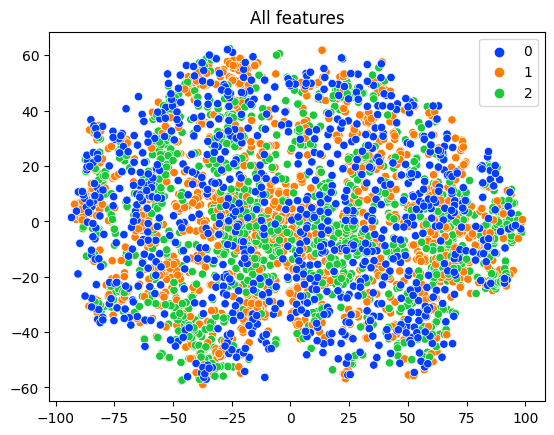

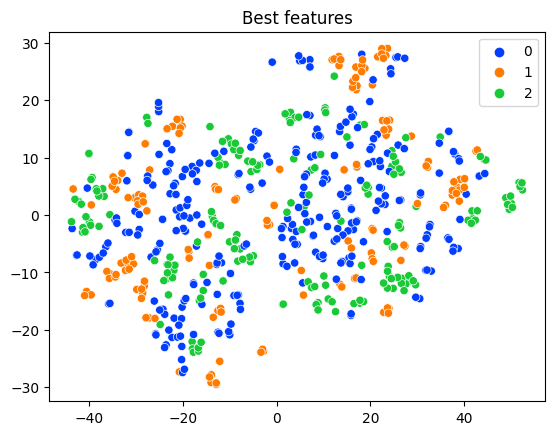

In [19]:
visualize_features(features, labels, 3, "All features")
visualize_features(best_features, labels_, 3, "Best features")

### 1.1.2. Discussion about SIFT features

Using the t-SNE tools we can visualize the high dimensional features (128 dimensions) extracted using the SIFT algorithm and plot them on the 2D plane. We have done this both for the initial features and for the best features that were selected using our proposed method.

We can see that in the first case we get a fuzzy and noisy result where the features of different classes overlap and are almost impossible to distinguish.

In the second case, it is obvious that the selected features show very good discriminative and robustness properties, as the features of different classes form clusters that are clearly separated.

NOTE:
The features presented above were extracted from the area of the eyes and nose and not from the whole face. This is done beacause they are invariant when the pose or the mood of the person change and therefore more robust than the area of the mouth. These features seem to have good properties, but depending on the results of the classification we may need to modify this

## 1.2. Baseline 2: PCA feature extractor


In [20]:
# ----- PREPROCESSING -----
#----- Gray scaling -----
n,w,h,d = train_X.shape

gray_train = np.zeros([n,w,h])
for k in range(0,n):
    gray_train[k] = cv2.cvtColor(train_X[k].astype(np.uint8),cv2.COLOR_RGB2GRAY)
    
img = gray_train[0:n].astype(np.uint8)

In [21]:
#IdentityFeatureExtractor
class PCAFeatureExtractor():
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
    
    def __call__(self, train_X):
        # ----- PREPROCESSING -----
        #----- Gray scaling -----
        n,w,h,d = train_X.shape

        gray_train = np.zeros([n,w,h])
        for k in range(0,n):
            gray_train[k] = cv2.cvtColor(train_X[k].astype(np.uint8),cv2.COLOR_RGB2GRAY)
            
        img = gray_train[0:n].astype(np.uint8)
        #----- center -----
        mean = np.mean(gray_train,axis=0).astype(np.uint8)
        self.mean = mean
        centered = (img-mean)/255 #no mean substraction
        #----- reshape into a 2D matrix-----
        X_scaled= centered.reshape((n,h*w))
        #----- decomposition ------
        U, Sigma, VT = np.linalg.svd(X_scaled, full_matrices=False)

        self.U= U
        self.S= Sigma
        self.VT= VT
        print("gray_train:", gray_train.shape)
        print("U:", U.shape)
        print("Sigma:", Sigma.shape)
        print("V^T:", VT.shape)
        # print("centered:", centered.shape)

        self.eigenfaces= np.reshape(VT,(n,w,h))*255
    
        Features = X_scaled@VT[:self.n_components,:].T
        return (Features)
    def inverse_transform(self, Features):
        n,w,h,d = train_X.shape
        X_reconstructed = Features@self.VT[:self.n_components,:]
        img_reconstructed = np.reshape(X_reconstructed,(n,w,h))*255 +self.mean
        return img_reconstructed.astype(np.uint8)

We plot the Sigma matrix that contains the singular values. One can see the relative importance of the first singular vectors to describe the image. 

In [84]:
sigma.shape

(80,)

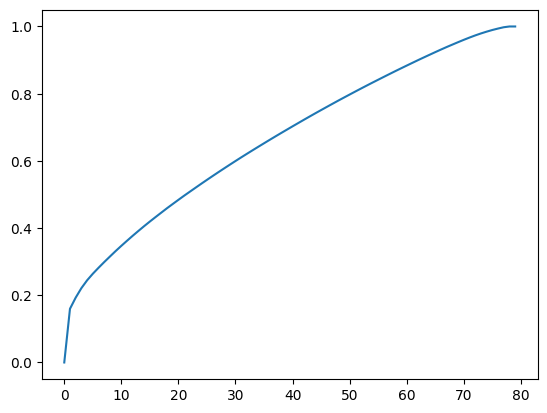

In [92]:
sigma= pca.S
n= sigma.shape[0]
somme = np.zeros([n,1])
for i in range(0,n):
    somme[i] = np.sum(sigma[0:i])/np.sum(sigma)

plt.plot(somme)

gray_train: (80, 150, 150)
U: (80, 80)
Sigma: (80,)
V^T: (80, 22500)


Text(0.5, 1.0, 'eigenvalues')

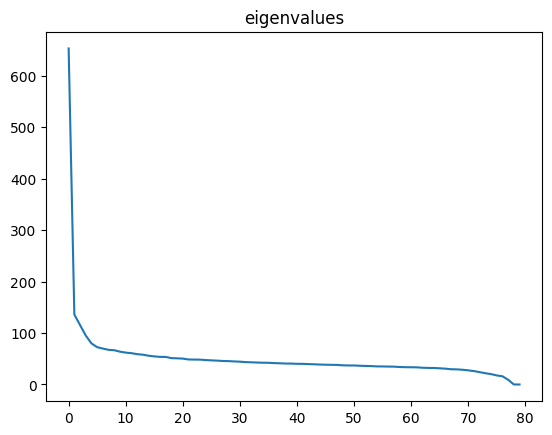

In [22]:
pca=PCAFeatureExtractor(n_components=60)

Features= pca(train_X)
sigma= pca.S
plt.figure()
plt.plot(sigma)
plt.title("eigenvalues")

We plot the mean image to see the information contained in it. We better not substract it to the dataset as it decribe well a face.

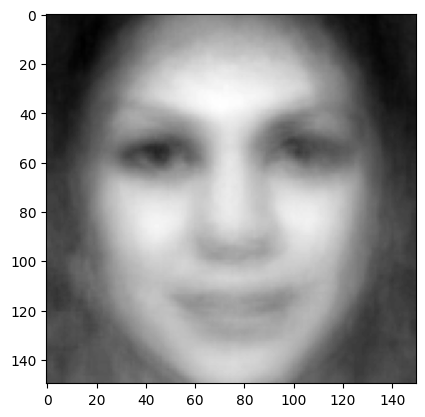

In [23]:
plt.imshow( pca.mean,cmap="gray")

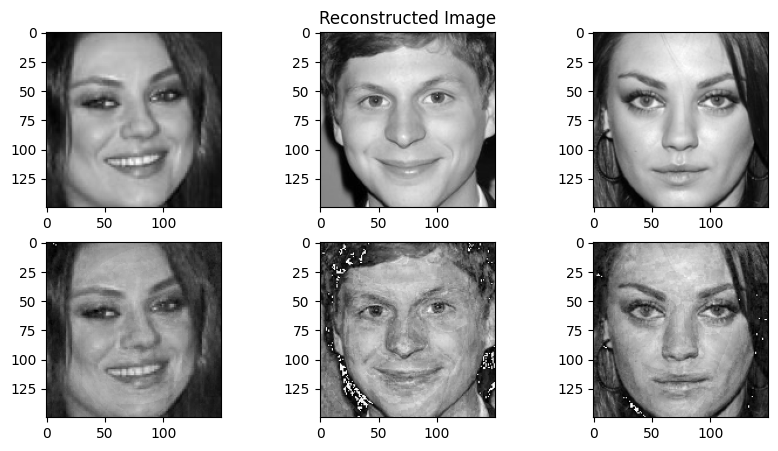

In [24]:
#----- reconstruction -----
img_reconstructed= pca.inverse_transform(Features)

#----- printing results -----
fig, ((ax1, ax2,ax3),(ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

ax1.imshow(cv2.cvtColor(train_X[1].astype(np.uint8),cv2.COLOR_RGB2GRAY),cmap='gray')
ax4.imshow(img_reconstructed[1],cmap='gray')
ax2.set_title('Reconstructed Image')
ax2.imshow(cv2.cvtColor(train_X[2].astype(np.uint8),cv2.COLOR_RGB2GRAY),cmap='gray')
ax5.imshow(img_reconstructed[2],cmap='gray')
ax3.imshow(cv2.cvtColor(train_X[3].astype(np.uint8),cv2.COLOR_RGB2GRAY),cmap='gray')
ax6.imshow(img_reconstructed[3],cmap='gray')
plt.show()


### 1.2.1. Eigenface Plots


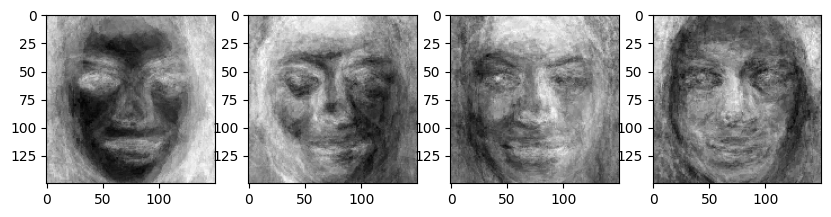

In [25]:
eigenfaces= pca.eigenfaces
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(10, 5))
ax1.imshow(eigenfaces[1],cmap='gray')
ax2.imshow(eigenfaces[2],cmap='gray')
ax3.imshow(eigenfaces[3],cmap='gray')
ax4.imshow(eigenfaces[4],cmap='gray')

### 1.2.2. Feature Space Plots


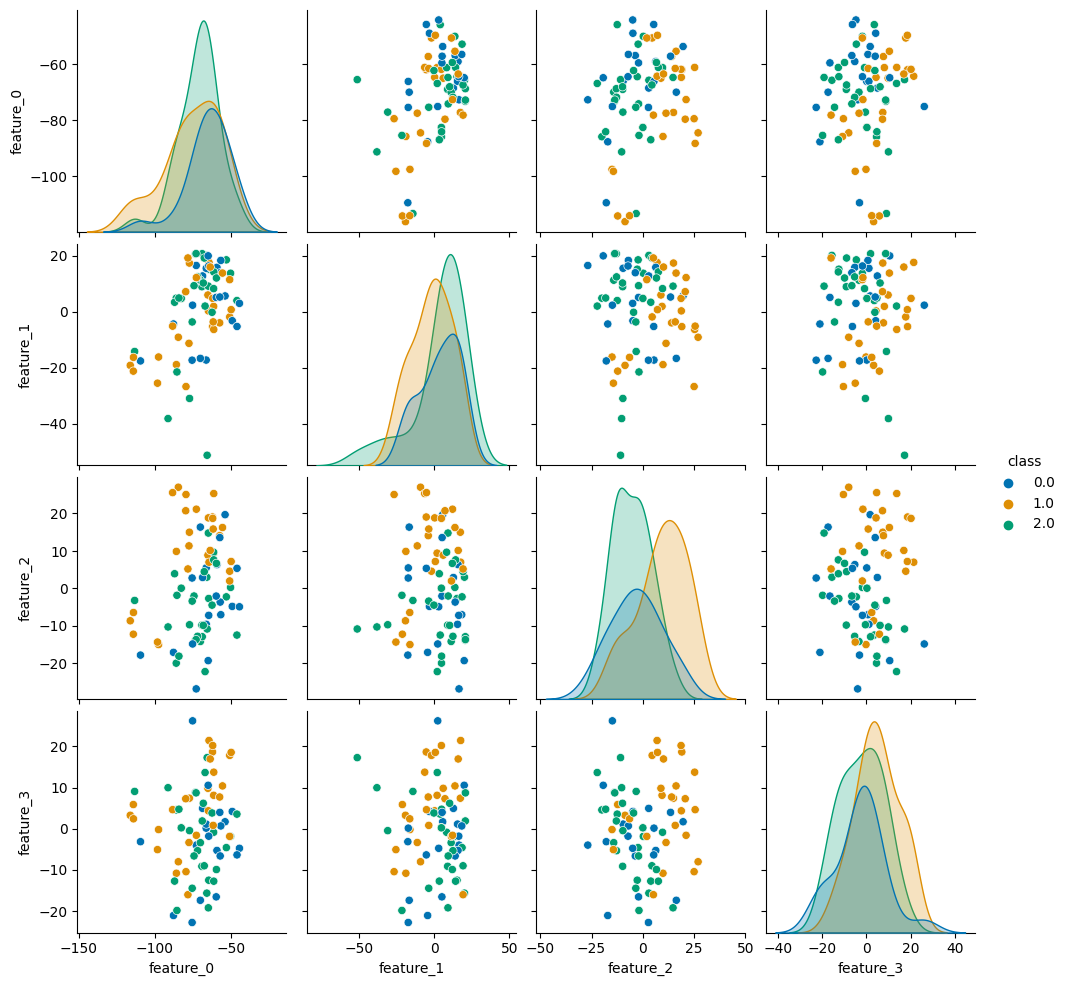

In [26]:
import seaborn as sns
import pandas as pd

# Combine Features and train_y into a single DataFrame
n_features = 4
data = pd.DataFrame(np.column_stack((Features[:,:n_features], train_y)), columns=[f"feature_{i}" for i in range(Features[:,:n_features].shape[1])] + ["class"])

# Create pairplot with color by "class"
sns.pairplot(data, hue="class", palette= "colorblind")

### 1.2.3. Discussion
The train set with 80 gray images of size 100x100 is reshaped to get a matrix 80x 10000. So that it corresponds to observations in rows and variables in columns. Now the goal is to get less than 10000 variables to describe the 80 observations.
We started to swich all the images into grayscale images and we have normalized the dataset. We chose to substract the mean because it gives better result while clissifing but it is worse when it comes to reconstruct the image. In fact, the mean contains quite importante information (see mean plot) to construct a face but the information we need to focus on to classify are the elements that make a person special (meaning diffferent from the mean).
The VT matrix contains the eigenfaces. The features are given by the data matrix projected onto VT. The dimensionnality is then reduces from 10000 to the number of samples (80 for the trainset) but it can be less. The less samples and the more dimension we have the greater the reduction is.
The  VT matrix is orthogonal. Hence, V@VT=Id so to reconstruct the image we just need to multiply by the inverse of VT which is V. 

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [27]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [28]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier


In [29]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    def __init__(self):
        from sklearn import svm
        self.model = svm.NuSVC()
        
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [30]:
feature_extractor = PCAFeatureExtractor(80) 
classifier = FavoriteClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

gray_train: (80, 150, 150)
U: (80, 80)
Sigma: (80,)
V^T: (80, 22500)


In [31]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

gray_train: (80, 150, 150)
U: (80, 80)
Sigma: (80,)
V^T: (80, 22500)


'The performance on the training set is 0.97. This however, does not tell us much about the actual performance (generalisability).'

In [32]:
# predict the labels for the test set 
test_y_star = model(test_X)

gray_train: (1816, 150, 150)
U: (1816, 1816)
Sigma: (1816,)
V^T: (1816, 22500)


## 4.1 HoG Pipeline
In this pipeline we extract the HoG features, train a KNN classification model and output the training accuracy and results. It's also prepared to do inference with other images.

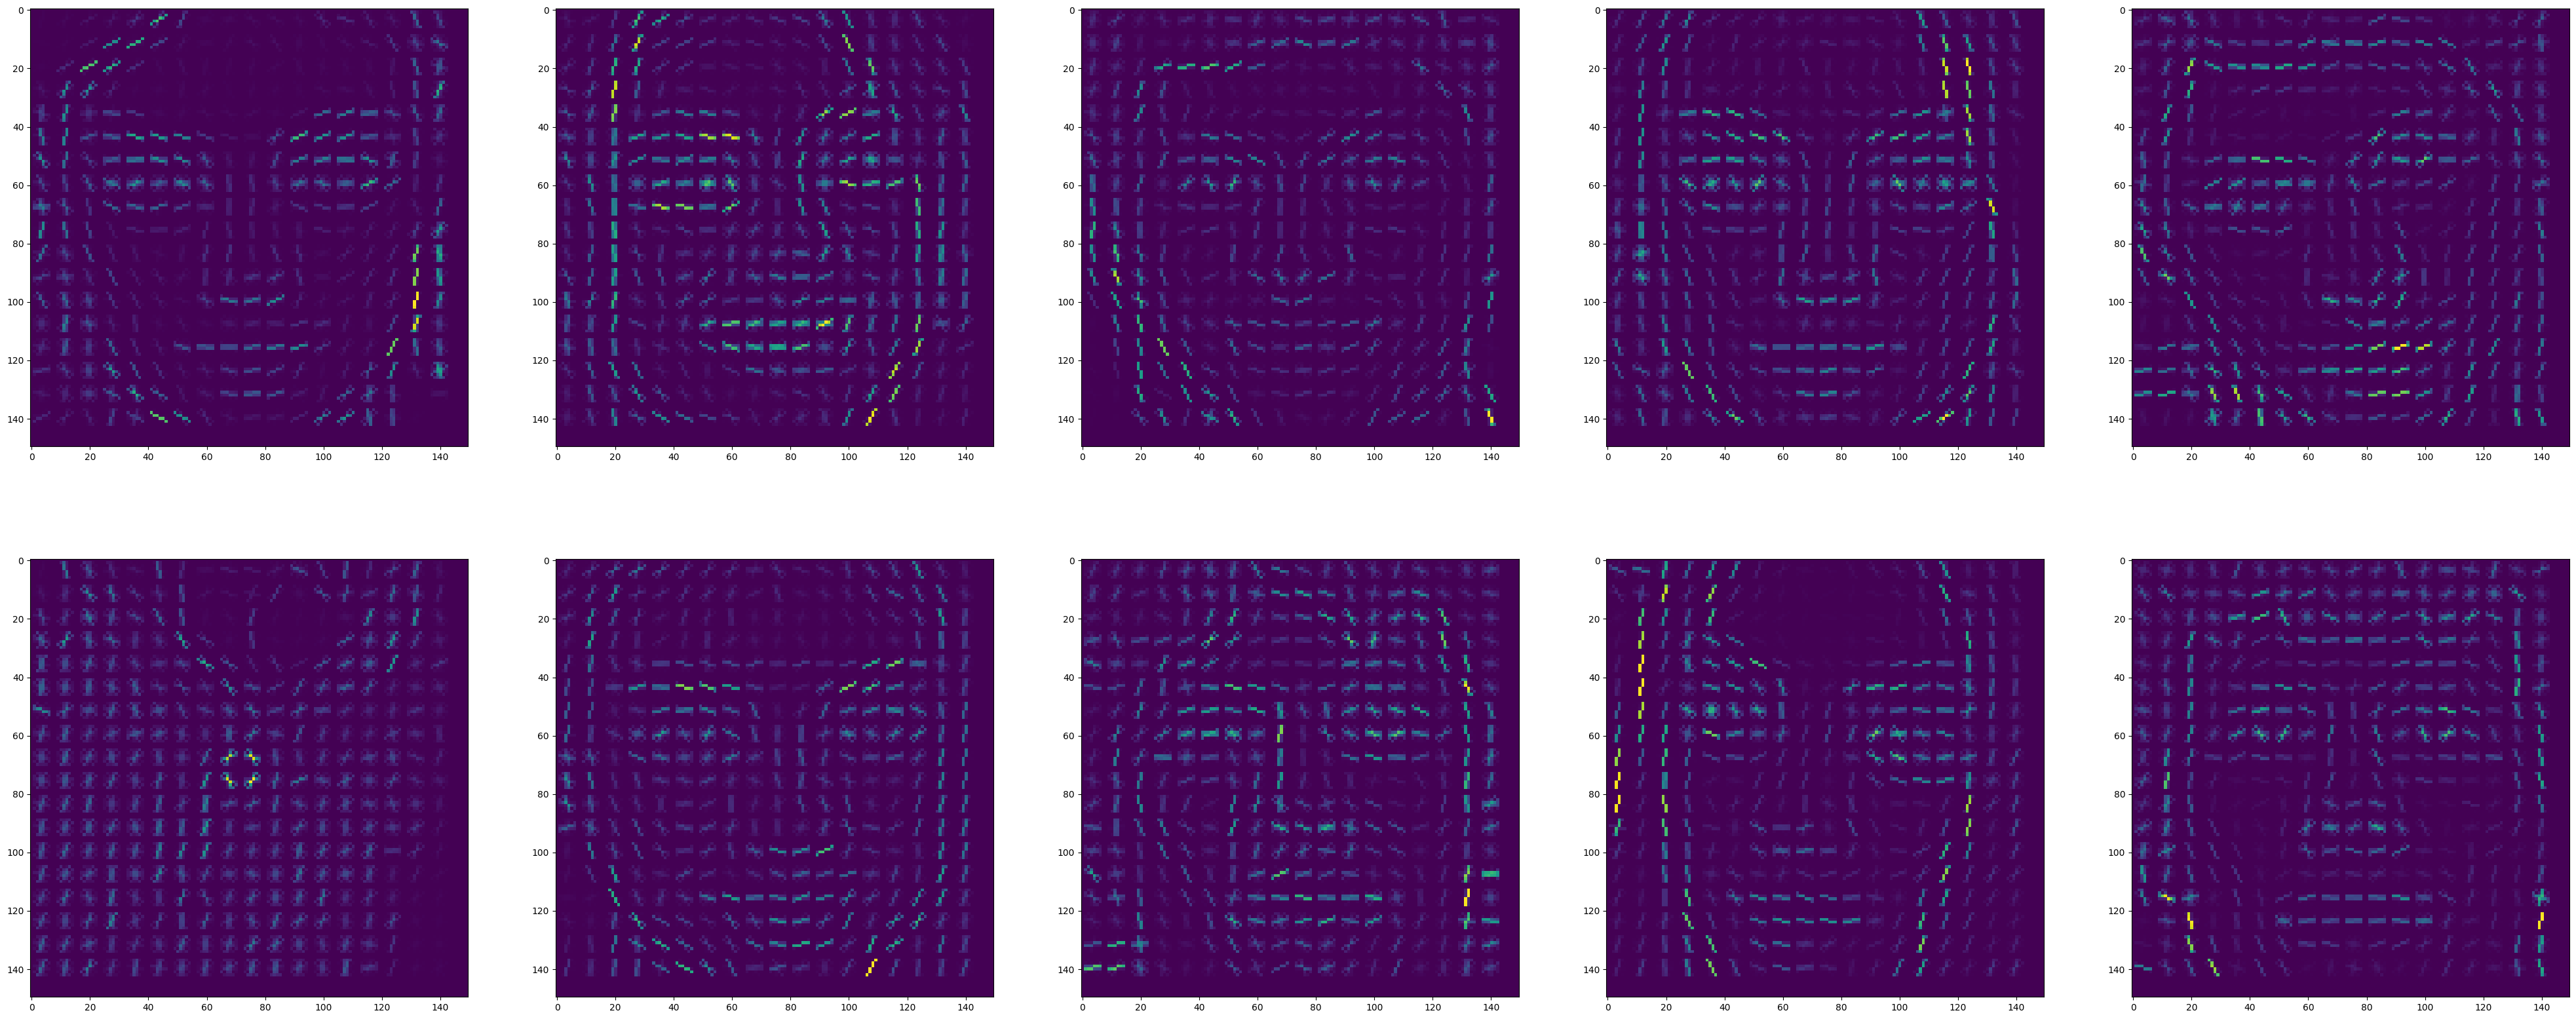

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


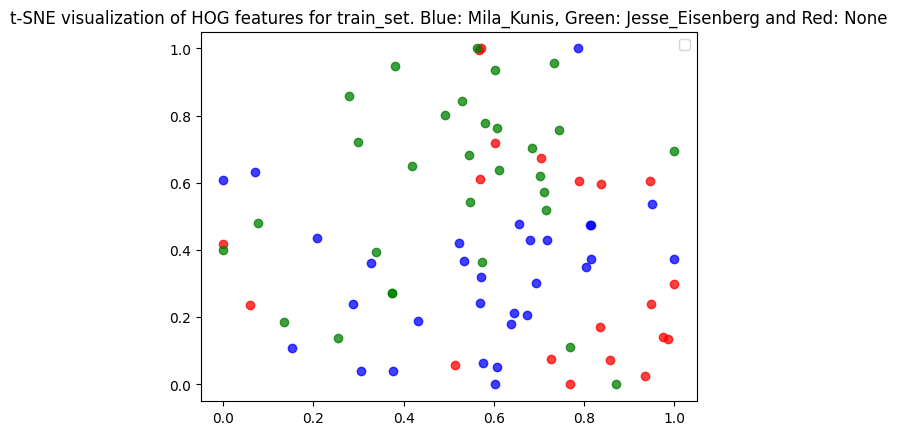

Training data and target sizes: 
(72, 9248), (72,)
Test data and target sizes: 
(8, 9248), (8,)
TEST ACCURACY: 1.0
Classification Report: 
 Target: HoG KNN 
 Labels: ['fakes', 'jesse', 'mila'] 
 Classifier: KNeighborsClassifier(algorithm='brute', n_neighbors=3):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.38      1.00      0.55         3

    accuracy                           0.38         8
   macro avg       0.12      0.33      0.18         8
weighted avg       0.14      0.38      0.20         8


Computing Random Forest


C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Mean Absolute Error: 0.56
Predictions:  [1.365      1.1047619  0.84333333 1.28666667 0.96333333 0.884
 0.97       1.04333333]
Expected:  [2, 0, 1, 2, 1, 0, 1, 2]
Accuracy: -inf %.


fakes  jesse  mila
fakes      0      0     2
jesse      0      0     3
mila       0      0     3

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor


# We create an objet of HOGFeatureExtractor
hog_feature_extractor = HOG()

hog_images = []
hog_features = []

for image in train_X:
    gray = cv2.cvtColor(image.astype(np.uint8),cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0) #Gaussian Filtering

    fd,hog_image = hog_feature_extractor.describe(blur)
    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)
hog_features.shape

# Plot some HOG images
plot_image_sequence(hog_images, 10, imgs_per_row=5)

# Plot t-SNE
fig = plt.figure()
ax = fig.add_subplot(111)

tsne = tsne_utils()

data_2d = tsne.generate_2d_data(hog_features)

fake_features = []
mila_features = []
jesse_features = []

for i in range(0,len(data_2d)):
    if train['class'][i] == 0:
        fake_features.append(list(data_2d[i]))
    elif train['class'][i] == 1:
        jesse_features.append(list(data_2d[i]))
    else:
        mila_features.append(list(data_2d[i]))
        
fake_features = np.array(fake_features)
mila_features = np.array(mila_features)
jesse_features = np.array(jesse_features)
                             
tsne.plot_tsne(fake_features, "red")
tsne.plot_tsne(jesse_features, "green")
tsne.plot_tsne(mila_features, "blue")
ax.legend(loc='best')

plt.title('t-SNE visualization of HOG features for train_set. Blue: Mila_Kunis, Green: Jesse_Eisenberg and Red: None' )
plt.show()

# Generate train dataset with the features
X_train, X_test, y_train, y_test = train_test_split(hog_features,train['class'],test_size=0.1,stratify=train['class'])

print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

# Compute Classifier KNN
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
knn_hog_classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
knn_hog_classifier.fit(X_scaled, y_train)
test_accuracy = knn_hog_classifier.score(scaler.transform(X_test), y_test)
y_pred = knn_hog_classifier.predict(X_test)
print(f"TEST ACCURACY: {test_accuracy}")


categories = ['fakes', 'jesse', 'mila']
target = "HoG KNN"
list_of_categories = categories
print("Classification Report: \n Target: %s \n Labels: %s \n Classifier: %s:\n%s\n"
      % (target,list_of_categories,knn_hog_classifier, metrics.classification_report(y_test, y_pred)))
df_report = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),columns = list_of_categories )
df_report.index = [list_of_categories]
df_report

print("Computing Random Forest")
# Compute Classifier Random Forest
rf = RandomForestRegressor(n_estimators = 100)

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

print('Predictions: ', predictions)
print('Expected: ', list(y_test))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

df_report

#CNN


In [61]:
def preprocess_CNN(train_X):
    n,w,h,d = train_X.shape
    gray_train = np.zeros([n,w,h])
    for k in range(0,n):
         gray_train[k] = cv2.cvtColor(train_X[k].astype(np.uint8),cv2.COLOR_RGB2GRAY)
    
    img = gray_train[0:n].astype(np.uint8)
    return img

Epoch 1/30
9/9 [==============================] - 6s 527ms/step - loss: 19.0333 - accuracy: 0.3359 - val_loss: 1.7273 - val_accuracy: 0.3448
Epoch 2/30
9/9 [==============================] - 4s 448ms/step - loss: 1.2621 - accuracy: 0.3745 - val_loss: 1.0678 - val_accuracy: 0.3448
Epoch 3/30
9/9 [==============================] - 4s 439ms/step - loss: 1.0630 - accuracy: 0.4479 - val_loss: 0.9569 - val_accuracy: 0.4483
Epoch 4/30
9/9 [==============================] - 4s 439ms/step - loss: 0.9266 - accuracy: 0.5869 - val_loss: 1.0686 - val_accuracy: 0.3103
Epoch 5/30
9/9 [==============================] - 4s 465ms/step - loss: 0.8916 - accuracy: 0.5135 - val_loss: 0.8697 - val_accuracy: 0.6552
Epoch 6/30
9/9 [==============================] - 4s 442ms/step - loss: 0.9274 - accuracy: 0.5830 - val_loss: 0.7887 - val_accuracy: 0.6897
Epoch 7/30
9/9 [==============================] - 4s 454ms/step - loss: 0.7306 - accuracy: 0.6834 - val_loss: 0.5784 - val_accuracy: 0.7586
Epoch 8/30
9/9 [===

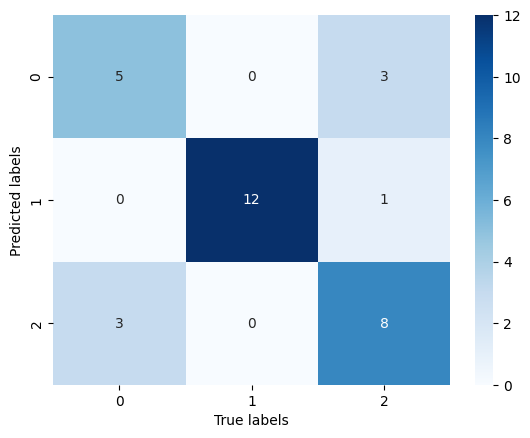

In [77]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


#----- split into train, validation and test set-----
data= preprocess_CNN(train_X)
X_train, X_test, y_train, y_test = train_test_split(data,train_y,test_size=0.1,stratify=train_y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,stratify=y_train)
n,w,h = data.shape
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(w,h,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compile the CNN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

# Train the CNN
model.fit(X_train, to_categorical(y_train), epochs=30, validation_data=(X_val, to_categorical(y_val)))

# Evaluate the performance
test_loss, test_acc = model.evaluate(X_test, to_categorical(y_test))
print('Test accuracy:', test_acc)
predictions = np.argmax(model.predict(X_test),axis=1)
print(list(predictions))

#plot confusion matrix
cm= confusion_matrix(predictions,y_test)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Predicted labels')
plt.xlabel('True labels')
plt.show()

## 4.2 PCA Pipeline

2
(160, 150, 150, 3)
(160,)
2
(320, 150, 150, 3)
(320,)


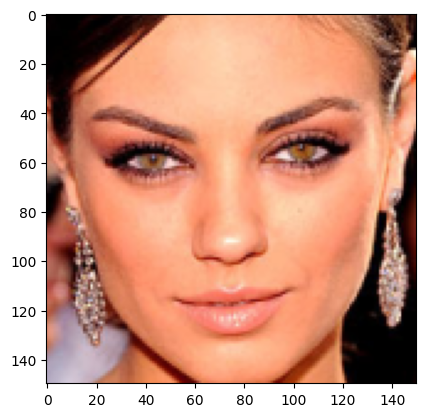

In [57]:
import imgaug.augmenters as iaa
repet = 2
for i in range(repet) :

    n,w,h,d = train_X.shape
    img = train_X.astype(np.uint8)


    plt.imshow(img[0])
    print(train_y[0])

    # Définir un augmenteur avec quelques techniques de data augmentation
    augmenter = iaa.Sequential([
        iaa.Affine(rotate=(-45, 45)),         # rotations aléatoires
        iaa.Fliplr(0.5),                      # flips horizontaux aléatoires
        iaa.GaussianBlur(sigma=(0, 1.0)),     # flou gaussien aléatoire
        iaa.AdditiveGaussianNoise(scale=0.1), # bruit gaussien aléatoire
    ])

    # Appliquer l'augmentation à vos images
    augmented_images = augmenter(images=img)

    # Répéter les étiquettes originales pour chaque image augmentée
    num_augmentations = augmented_images.shape[0] // n
    augmented_labels = np.repeat(train_y, num_augmentations)

    # Générer des étiquettes pour les nouvelles images augmentées
    new_labels = np.zeros(augmented_images.shape[0], dtype=train_y.dtype)
    new_labels[:n] = train_y

    # Concaténer les étiquettes répétées avec les nouvelles étiquettes
    final_labels = np.concatenate([augmented_labels, new_labels])

    # Concaténer les images d'origine avec les images augmentées
    final_images = np.concatenate([img, augmented_images])

    train_X= final_images
    train_y = final_labels

    print(final_images.shape)
    print(final_labels.shape)

In [52]:
print(train_X_rich.shape)

(100, 150, 150, 3)


gray_train: (320, 150, 150)
U: (320, 320)
Sigma: (320,)
V^T: (320, 22500)
score on trainning 0.9196428571428571
Mean Absolute Error: 33.0
Predictions:  [2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 1 2 2 1 1 2 0 1 2 1 2 2 2 2 2 1 2 1 2 0 2 2
 1 0 0 2 2 2 2 2 1 2 1 1 2 2 2 0 1 1 2 2 2 0 1 2 0 0 2 2 1 1 0 1 1 2 2 2 1
 2 1 0 0 0 1 2 2 2 1 2 0 0 2 1 1 2 1 1 1 2 2]
Expected:  [0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2]
Accuracy: 65.62 %.


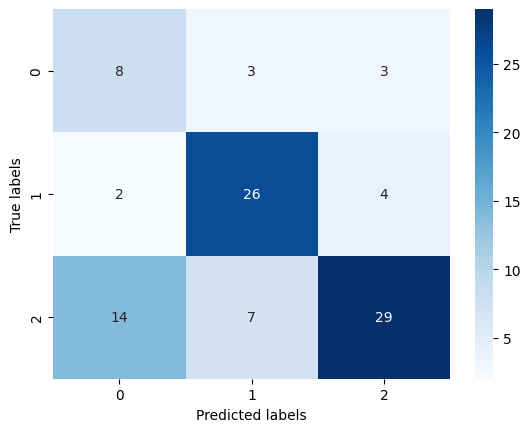

fakes  jesse  mila
fakes      0      0     2
jesse      0      0     3
mila       0      0     3

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import svm
# We create an objet of PCAFeatureExtractor
n_train = train_X.shape[0]
feature_extractor = PCAFeatureExtractor(n_train) 
PCA_features= feature_extractor(train_X)

X_train, X_test, y_train, y_test = train_test_split(PCA_features,train_y,test_size=0.3,stratify=train_y)

classifier = svm.NuSVC(nu=0.7)
# train the model on the features

classifier.fit(X_train, y_train)

# evaluate performance of the model on the training set
train_y_star = classifier.predict(X_train)

print("score on trainning",accuracy_score(y_train, train_y_star))

# predict the labels for the test set 
predictions = classifier.predict(X_test)

# Calculate the absolute errors
errors = sum(predictions != y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

print('Predictions: ', predictions)
print('Expected: ', list(y_test))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test.shape)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

cm= confusion_matrix(predictions,y_test)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

df_report

In [68]:
n_train = train_X.shape[0]
feature_extractor = PCAFeatureExtractor(n_train) 
test_y_star = classifier.predict(feature_extractor(test_X))

gray_train: (1816, 150, 150)
U: (1816, 1816)
Sigma: (1816,)
V^T: (1816, 22500)


In [69]:
test_y = model.predict(preprocess_CNN(test_X))
test_y_CNN = np.argmax(test_y,axis=1)

57/57 [==============================] - 3s 41ms/step


In [72]:
print(test_y_CNN.shape)

(1816,)


In [73]:
for i in range(0,1816):
    if test_y_CNN[i]==0:
        test_y_star[i]=0

### 4.3 SIFT Pipeline

The following classifier uses the SIFT features extracted from an image in order to classify it. Namely the prediction process inlcudes the following:
* Extract the features from the image using the SIFT extractor. Features are extracted from the area of the eyes and the nose and this seems to give better results as expected and desrcibed above (see TSNE discussion about SIFT features).
* Keep the ***good features*** that match the already extracted features from the train set (regardless the class they come from). Use the Lowe ratio test for that.
* Classify each good feature using a 2-nearest-neighbor classifier. Each class receives a vote for every good feature assinged to it.
* Classify the image into the class that received the most votes. In case of a tie choose randomly (for this we rely on the discriminative property of the features).

In [36]:
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifier:
    
    def __init__(self, neighbors=2):
        self.neighbors = neighbors

    
    def fit(self, X, y):
        n_kps, features, labels = clean_and_assign_labels(X, y)

        # Select the best features and their corresponding labels
        best_features, labels_ = select_best_features(n_kps, features, labels, ratio=0.75)
        
        # Fit the knn classifier using the best features
        neigh = KNeighborsClassifier(n_neighbors=self.neighbors, p=2, weights="distance")
        self.clf = neigh.fit(best_features, labels_)
        self.jesse_features = best_features[labels_==1]
        self.mila_features = best_features[labels_==2]
        self.false_features = best_features[labels_==0]
        return self
    
    
    def predict(self, X):
        y_star = []
        ratio = 0.75
        bf = cv2.BFMatcher()
        
        for des in X:
            if des is None or len(des)<2:
                y_star.append(0)
            else:
                # Find the feature that match well with the 
                # extracted features from the train data
                good = np.zeros((1,128), dtype=np.uint8)
                matches = bf.knnMatch(des,self.jesse_features,k=2)
                
                # Apply the ratio test proposed by Lowe to consider
                # only good matches between the two images
                for m,n in matches:
                    if m.distance < ratio*n.distance:
                        good = np.append(good, [des[m.queryIdx]], axis=0)

                matches = bf.knnMatch(des,self.mila_features,k=2)
               
                # Apply the ratio test proposed by Lowe to consider
                # only good matches between the two images
                for m,n in matches:
                    if m.distance < ratio*n.distance:
                        good = np.append(good, [des[m.queryIdx]], axis=0)
                
                matches = bf.knnMatch(des,self.false_features,k=2)
                
                # Apply the ratio test proposed by Lowe to consider
                # only good matches between the two images
                for m,n in matches:
                    if m.distance < ratio*n.distance:
                        good = np.append(good, [des[m.queryIdx]], axis=0)
                
                # Predict the class of each feature and choose the class
                # that has the most votes
                good = good[1:]
                if len(good)==0:
                    y_star.append(0)
                else:
                    pred = self.clf.predict(good)
                    votes = np.empty((3,), dtype=int)
                    votes[0] = np.count_nonzero(pred==0)
                    votes[1] = np.count_nonzero(pred==1)
                    votes[2] = np.count_nonzero(pred==2)

                    y_star.append(np.argmax(votes))
        
        return np.array(y_star)

In [49]:
print(feature_extractor.transform(X_train,mask)[1].shape)

(37, 128)


In [46]:
from sklearn.model_selection import train_test_split

# Use the augmented train set
X_train, X_test, y_train, y_test = train_test_split(train_X_rich, train_y_rich,
                                                    test_size=0.33, random_state=50)
print(X_train.shape)
print(X_test.shape)
# Extract features and use them to fit the classifier
feature_extractor = SIFTFeatureExtractor(contrastThreshold=0.04, edgeThreshold=20) 
mask = create_mask(30, 100, 20, 120)
clf = KNNClassifier(neighbors=2).fit(feature_extractor.transform(X_train,mask), y_train)

# Predict the labels
feature_extractor = SIFTFeatureExtractor(contrastThreshold=0.04, edgeThreshold=20)
train_y_star = clf.predict(feature_extractor.transform(X_test,mask))

# Compute accuracy score
"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(y_test, train_y_star))

(67, 150, 150, 3)
(33, 150, 150, 3)


'The performance on the training set is 0.85. This however, does not tell us much about the actual performance (generalisability).'

In [ ]:
# Use the whole (augmented) train set to train the classifier
clf = KNNClassifier(neighbors=2).fit(feature_extractor.transform(train_X_rich,mask), train_y_rich)

# Predict the labels of the test set
test_y_star = clf.predict(feature_extractor.transform(test_X,mask))

# 5. Publishing best results

In [74]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         2
4         2
...     ...
1811      2
1812      0
1813      0
1814      0
1815      0

[1816 rows x 1 columns]

In [75]:
submission.to_csv('submission.csv')

# 6. Discussion
In summary we contributed the following: 
* SIFT Pipeline: The accuracy achieved reaches 73% which is satisfying given the limited amount of the training images. Data augmentation, via e.g. noise, blurring or rotation, does not increase the accuracy of the model. Also, different classifiers such as MLPs ans SVMs were tested for the classification of the features, but the 2NN classifier had the best performance. 
